In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from financepy.utils import *
from financepy.products.rates import *
from tqdm import tqdm
import datetime
import pickle

读取处理过的数据，保留数据齐全的数据，调整时间格式

In [65]:
df = pd.read_excel('micro_rv_euro.xlsx')
df.dropna(inplace=True) # dates where all benchmark instruments are available
# convert date to format dd-mm-yyyy
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
# convert to float
df = df.astype(np.float32)


In [ ]:
columns = ['1w','2w']
for i in [1,2,3,4,5,6,7,8,9,10,11]:
    columns.append(str(i)+'M')
columns.append('1Y')
columns.append('18M')


for i in [2,3,4,5,6,7,8,9,10,11,12,15,20,25,30,40,50]:
    columns.append(str(i)+'Y')

for old_name, new_name in zip(df.columns, columns):
    df.rename(columns={old_name: new_name}, inplace=True)

In [68]:
df

,1w,2w,1M,2M,3M,4M,5M,6M,7M,8M,...,9Y,10Y,12Y,15Y,20Y,25Y,30Y,40Y,50Y,EESWE50 Curncy
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,-0.5772,-0.5759,-0.5765,-0.5743,-0.5730,-0.5709,-0.5675,-0.5638,-0.5560,-0.5502,...,0.1495,0.1968,0.2390,0.2813,0.3700,0.4165,0.3981,0.3572,0.2832,0.2150
2022-01-28,-0.5770,-0.5760,-0.5754,-0.5745,-0.5721,-0.5705,-0.5675,-0.5612,-0.5533,-0.5462,...,0.1770,0.2240,0.2670,0.3070,0.3990,0.4420,0.4210,0.3810,0.3050,0.2410
2022-01-31,-0.5770,-0.5755,-0.5750,-0.5715,-0.5715,-0.5685,-0.5587,-0.5547,-0.5444,-0.5325,...,0.2210,0.2620,0.3080,0.3413,0.4270,0.4680,0.4460,0.4020,0.3311,0.2800
2022-02-01,-0.5765,-0.5753,-0.5745,-0.5735,-0.5715,-0.5695,-0.5620,-0.5523,-0.5416,-0.5321,...,0.2340,0.2770,0.3180,0.3570,0.4430,0.4870,0.4690,0.4310,0.3570,0.3030
2022-02-02,-0.5760,-0.5755,-0.5745,-0.5735,-0.5720,-0.5678,-0.5615,-0.5520,-0.5417,-0.5310,...,0.2550,0.2965,0.3360,0.3710,0.4530,0.4877,0.4651,0.4230,0.3480,0.2850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-15,3.1648,3.1628,3.1182,3.0041,2.9125,2.8242,2.7113,2.6135,2.4960,2.4150,...,2.1751,2.2120,2.1868,2.2470,2.3098,2.2777,2.1850,2.1011,1.9518,1.8070
2024-11-18,3.1632,3.1629,3.0830,3.0070,2.8993,2.8166,2.7070,2.6070,2.5387,2.4686,...,2.1895,2.2030,2.2100,2.2641,2.2989,2.2726,2.1891,2.1058,1.9611,1.8183
2024-11-19,3.1645,3.1620,3.0587,3.0120,2.8850,2.7990,2.7080,2.5810,2.5285,2.4615,...,2.1715,2.1315,2.2239,2.2508,2.2427,2.2234,2.1435,2.0666,1.9255,1.7876


将各期限转为年为单位，并构建dictionary

In [69]:
# convert tenors to numpy array in the unit of year
tenors = np.array([1/52,2/52,1/12,2/12,3/12,4/12,5/12,6/12, 7/12, 8/12, 9/12, 10/12,11/12, 12/12, 18/12,  2, 3, 4, 5, 6, 7, 8, 9, 10,11,12, 15, 20, 25, 30, 40, 50])
# a dictionary that match column names to tenors
tenors_dict = dict(zip(df.columns, tenors))
# fit a hermite spline to first row with selected tenors
selected_tenors = df.columns # select some tenors not all to show that the curve is interpolated
x = np.array([tenors_dict[i] for i in selected_tenors])
date = df.index[0]
y = df.loc[date, selected_tenors].values

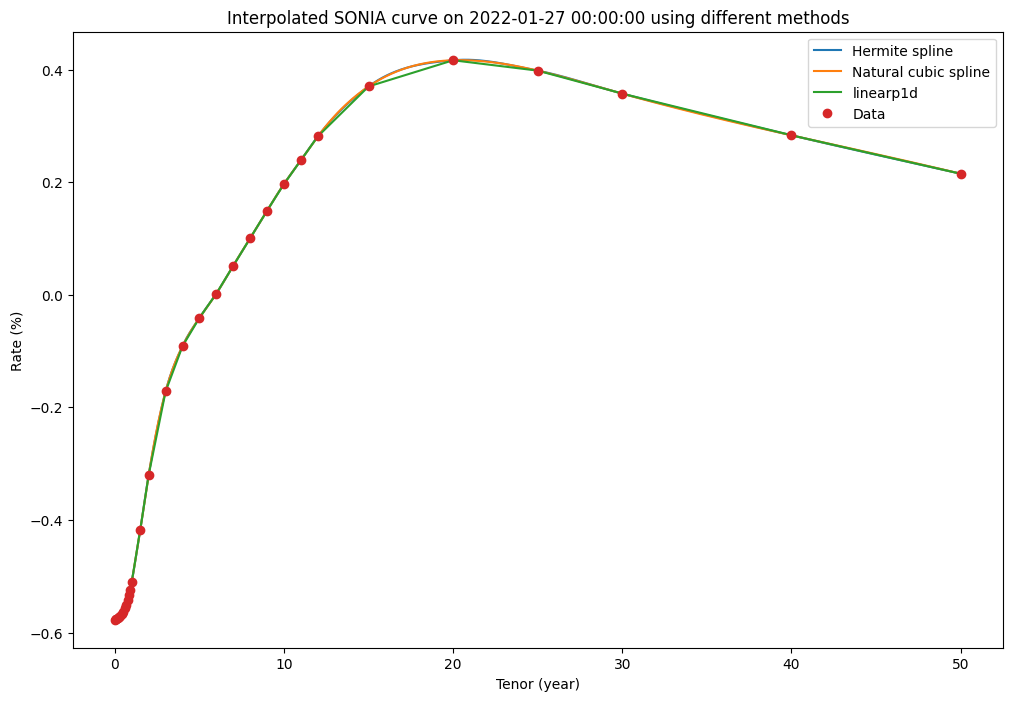

In [70]:
# cubic hermite spline
cs = CubicHermiteSpline(x, y, np.gradient(y, x), axis=0)
# natural cubic spline
cs_natrual = CubicSpline(x, y)
# linear
cs_linear = interp1d(x, y)

# interpolate
xnew = np.arange(6/12,50,1/12) # every month
ynew = cs(xnew)
ynew_natrual = cs_natrual(xnew)
ynew_linear = cs_linear(xnew)
#plot natrual cubic spline
plt.figure(figsize=(12,8))
plt.plot(xnew, ynew, '-', label='Hermite spline')
plt.plot(xnew, ynew_natrual, '-', label='Natural cubic spline')
plt.plot(xnew, ynew_linear, '-', label='linearp1d')

plt.plot(x,y,'o', label='Data')
plt.xlabel('Tenor (year)')
plt.legend()
plt.title(f'Interpolated SONIA curve on {date} using different methods')
plt.ylabel('Rate (%)')
plt.savefig("Example1.pdf",format = "pdf")

In [71]:
def plotCurve(curve, start_date, tmax, instr_mat_dates_or_tenor = None, title = ''):
    """
    Plots zero rates, ON fwd rates and term fwd rates for a curve
    Inputs:
    curve: IborSingleCurve
    start_date: Date
    tmax: float, max time in years
    instr_mat_dates_or_tenor: None or list of Dates or a tenor string
    title: str, title of the plot
    """
    years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
    dates = start_date.add_years(years) # the array of end dates for the curve
    zero_rates = curve.zero_rate(dates) # zero_rate
    on_fwd_rates = curve.fwd(dates) # ON fwd rates

    ys_monthly = np.arange(1,tmax*12+1)/12
    monthly_dates = start_date.add_years(ys_monthly)

    if instr_mat_dates_or_tenor is not None:
        # Will plot term forward rates
        # instr_mat_dates_or_tenor could be a list of curve-building
        # isntrument maturities in which case term fwd rates go from the last instrument maturiy date that is less
        # than the plotting date to the plotting date. Or it could be a tenor so that fwd rates cover that tenor 
        # i.e. the term fwd rate for d covers [max(d-tenor,start_date), d]
        # tenor should be a positive tenor

        if isinstance(instr_mat_dates_or_tenor, str):
            neg_tenor = '-' + instr_mat_dates_or_tenor
            start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
            start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
            fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'
        else:
            instr_mat_dates_or_tenor = [start_date] + instr_mat_dates_or_tenor
            start_fwd_dates = [ max([md  for md in instr_mat_dates_or_tenor if md < d]) for d in dates]
            fwd_rate_label = 'term fwd rates from prev instr mtrty'

        term_fwd_rates = curve.fwd_rate(start_fwd_dates, dates)

    plt.figure(figsize=(8,6))
    plt.plot(years, zero_rates*100, '-', label="zero rates")
    plt.plot(years, on_fwd_rates*100, '-', label = "ON fwd rates")

    if instr_mat_dates_or_tenor is not None:
        plt.plot(years, term_fwd_rates*100, '.', label = fwd_rate_label)

    plt.xlabel("Times in years")
    plt.ylabel("Rates (%) - See Legend")
    plt.title(title)
    plt.legend()

In [72]:
# Demonstrate fitting a curve using the first date
valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
spot_days = 0 # T+0 as shown in Bloomberg ticker
settlement_date = valuation_date.add_weekdays(spot_days)
cal = CalendarTypes.TARGET
# store SONIA swap as we only have swap as benchmark instruments
swaps = []
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_360 
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_360 

for tenor in df.columns:
   if tenor[-1]=='Y': # only append yearly tenors for swap
      rate = df.loc[df.index[0], tenor]/100 # convert to %
      swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                      fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                      float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
      swaps.append(swap)

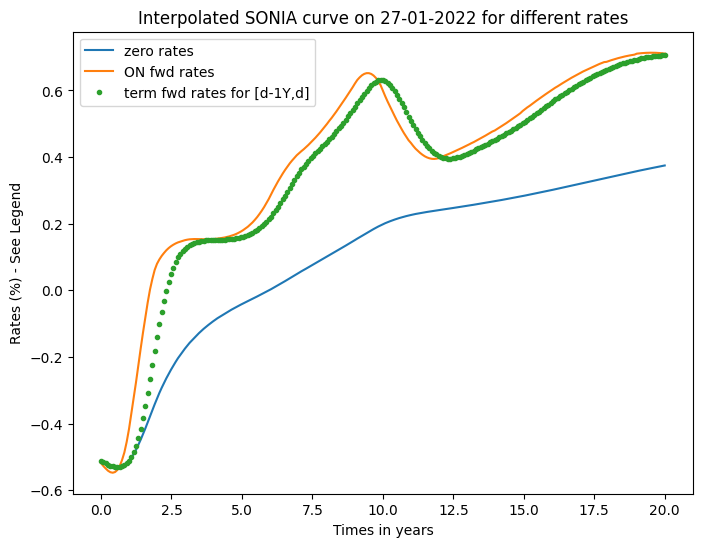

In [73]:
curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.NATCUBIC_ZERO_RATES) 
plotCurve(curve, valuation_date, 20, instr_mat_dates_or_tenor='1Y')
plt.title(f'Interpolated SONIA curve on {df.index[0].strftime("%d-%m-%Y")} for different rates')
plt.savefig("example2.pdf",format="pdf")

In [74]:
# create a yield curve dataset with columns in years, and rows same as df.index
# create a curves dictionary to store the calibrated curve for each date
curves = {}
year_columns = list(df.columns[df.columns.str.endswith('Y')]) # list of yearly tenors
year_columns = [int(i[:-1]) for i in year_columns] # convert to int
df_yield = pd.DataFrame(index=df.index, columns=year_columns) # 1y to 25y
# swap characteristics
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_360 # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_360 # 365 fixed

In [75]:
year_columns

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 50]

In [76]:
# create a yield curve dataset with columns in years, and rows same as df.index
# create a curves dictionary to store the calibrated curve for each date
curves = {}
year_columns = list(df.columns[df.columns.str.endswith('Y')]) # list of yearly tenors
year_columns = [int(i[:-1]) for i in year_columns] # convert to int
df_yield = pd.DataFrame(index=df.index, columns=year_columns) # 1y to 25y
# swap characteristics
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_360 # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_360 # 365 fixed

for date in tqdm(df.index, desc='Creating curves'): # loop through each date in the dataset
    swaps = []
    day, month, year = date.day, date.month, date.year
    valuation_date = Date(day, month, year) # convet to Date object
    spot_days = 0 # T+0
    settlement_date = valuation_date.add_weekdays(spot_days)
    for tenor in df.columns: # loop through each tenor in the dataset
        if tenor[-1]=='Y':
            rate = df.loc[date, tenor]/100
            swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                            fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
            swaps.append(swap)

    curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.NATCUBIC_ZERO_RATES)
    for year in year_columns:
        df_yield.loc[date, year] = curve.swap_rate(effective_dt=valuation_date,maturity_dt=valuation_date.add_years(year))
    curves[date] = curve # add this curve to the dictionary

Creating curves: 100%|██████████| 728/728 [11:09<00:00,  1.09it/s]


In [63]:
# store the curves dictionary and df_yield to a pickle file
with open('curves_eur.pkl', 'wb') as f:
    pickle.dump(curves, f) # store the curves dictionary
df_yield.to_pickle('df_yield_eur.pkl')